In [1]:
import os
import time
import pickle
import pdb

import numpy as np

import sklearn.preprocessing as skprep

import ot
import sklearn.metrics
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
from torch.utils.model_zoo import load_url
from torchvision import transforms

In [2]:
from cirtorch.networks.imageretrievalnet import init_network, extract_interest_points_mac
from cirtorch.datasets.datahelpers import cid2filename
from cirtorch.datasets.testdataset import configdataset
from cirtorch.utils.download import download_train, download_test
from cirtorch.utils.whiten import whitenlearn, whitenapply
from cirtorch.utils.evaluate import compute_map_and_print
from cirtorch.utils.general import get_data_root, htime

In [3]:
download_test(get_data_root())

In [4]:
dataset = 'oxford5k'
network_path = 'http://cmp.felk.cvut.cz/cnnimageretrieval/data/networks/retrieval-SfM-120k/rSfM120k-tl-resnet50-gem-w-97bf910.pth'
image_size = 1024

In [5]:
state = load_url(network_path, model_dir=os.path.join(get_data_root(), 'networks'))
net_params = {}
net_params['architecture'] = state['meta']['architecture']
net_params['pooling'] = state['meta']['pooling']
net_params['local_whitening'] = state['meta'].get('local_whitening', False)
net_params['regional'] = state['meta'].get('regional', False)
net_params['whitening'] = state['meta'].get('whitening', False)
net_params['mean'] = state['meta']['mean']
net_params['std'] = state['meta']['std']
net_params['pretrained'] = False
net = init_network(net_params)
net.load_state_dict(state['state_dict'])
net.eval()
normalize = transforms.Normalize(
    mean=net.meta['mean'],
    std=net.meta['std']
)
transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])
cfg = configdataset(dataset, os.path.join(get_data_root(), 'test'))

In [6]:
def plot_matches(ax, image1, image2, keypoints1, keypoints2, matches,
                 keypoints_color='k', matches_color=None, only_matches=False,
                 alignment='horizontal'):

    new_shape1 = list(image1.shape)
    new_shape2 = list(image2.shape)

    if image1.shape[0] < image2.shape[0]:
        new_shape1[0] = image2.shape[0]
    elif image1.shape[0] > image2.shape[0]:
        new_shape2[0] = image1.shape[0]

    if image1.shape[1] < image2.shape[1]:
        new_shape1[1] = image2.shape[1]
    elif image1.shape[1] > image2.shape[1]:
        new_shape2[1] = image1.shape[1]

    if new_shape1 != image1.shape:
        new_image1 = np.zeros(new_shape1, dtype=image1.dtype)
        new_image1[:image1.shape[0], :image1.shape[1]] = image1
        image1 = new_image1

    if new_shape2 != image2.shape:
        new_image2 = np.zeros(new_shape2, dtype=image2.dtype)
        new_image2[:image2.shape[0], :image2.shape[1]] = image2
        image2 = new_image2

    offset = np.array(image1.shape)
    if alignment == 'horizontal':
        image = np.concatenate([image1, image2], axis=1)
        offset[0] = 0
    elif alignment == 'vertical':
        image = np.concatenate([image1, image2], axis=0)
        offset[1] = 0
    else:
        mesg = ("plot_matches accepts either 'horizontal' or 'vertical' for "
                "alignment, but '{}' was given. See "
                "https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.plot_matches "  # noqa
                "for details.").format(alignment)
        raise ValueError(mesg)

    ax.imshow(image, interpolation='nearest', cmap='gray')
    ax.axis((0, image1.shape[1] + offset[1], image1.shape[0] + offset[0], 0))

    for i in range(matches.shape[0]):
        idx1 = matches[i, 0]
        idx2 = matches[i, 1]

        if matches_color is None:
            color = np.random.rand(3)
        else:
            color = matches_color

        ax.plot((keypoints1[idx1, 1], keypoints2[idx2, 1] + offset[1]),
                (keypoints1[idx1, 0], keypoints2[idx2, 0] + offset[0]),
                '-', color=color, linewidth=2)


In [7]:
## mutual matches ##
def mutual_max(P, threshold) :
    scores = torch.FloatTensor(P).unsqueeze(0)
    
    max0, max1 = scores.max(2), scores.max(1)
    indices0, indices1 = max0.indices, max1.indices

    mutual0 = torch.LongTensor(range(indices0.shape[1]))[None] == indices1.gather(1, indices0)
    mutual1 = torch.LongTensor(range(indices1.shape[1]))[None] == indices0.gather(1, indices1)

    zero = scores.new_tensor(0)
    mscores0 = torch.where(mutual0, max0.values, zero)
    mscores1 = torch.where(mutual1, mscores0.gather(1, indices1), zero)
    
    valid0 = mutual0 & (mscores0 > threshold)
    valid1 = mutual1 & valid0.gather(1, indices1)
    indices0 = torch.where(valid0, indices0, indices0.new_tensor(-1))
    indices1 = torch.where(valid1, indices1, indices1.new_tensor(-1))

    # make norm
    return indices0.flatten().numpy(), indices1.flatten().numpy(), mscores0.flatten().numpy(), mscores1.flatten().numpy()

In [88]:
q_idx = 0
p_idx = 2
n_idx = 0

qimage = [ cfg['qim_fname'](cfg, q_idx) ]
qgnd_images = [ cfg['im_fname'](cfg,j) for j in [ cfg['gnd'][q_idx]['ok'][p_idx] ] ]
# qgndj_images = [ cfg['im_fname'](cfg,j) for j in cfg['gnd'][q_idx]['junk'][:3] ]

In [89]:
q_descriptors, q_locations, q_scores = extract_interest_points_mac(net, qimage, 1024, transform)
qgnd_descriptors, qgnd_locations, qgnd_scores = extract_interest_points_mac(net, qgnd_images, 1024, transform)
# qgndj_descriptors, qgndj_locations, qgndj_scores = extract_interest_points_mac(net, qgndj_images, 1024, transform)


q_descriptors = q_descriptors.numpy()
q_locations = q_locations.numpy()

qgnd_descriptors = qgnd_descriptors.numpy()
qgnd_locations = qgnd_locations.numpy()

# qgndj_descriptors = qgndj_descriptors.numpy()
# qgndj_locations = qgndj_locations.numpy()

q_scores = q_scores.numpy()
qgnd_scores = qgnd_scores.numpy()
# qgndj_scores = qgndj_scores.numpy()



In [90]:
select_1 = q_scores.flatten().argsort()[-100:][::-1] # q_scores[0] > 30 #top10??
scores_1 = q_scores[0, select_1]
desc_1 = q_descriptors[0, select_1, :]
loc_1 = q_locations[0, select_1, :]
loc_1, unique_1, _ = np.unique(loc_1, axis=0, return_index=True, return_inverse=True)
desc_1 = desc_1[unique_1, :]
scores_1 = scores_1[unique_1]

In [91]:
desc_1.shape

(61, 2048)

In [92]:
select_2 = qgnd_scores[0, :].flatten().argsort()[-100:][::-1] # qgnd_scores[0] > 30
scores_2 = qgnd_scores[0, select_2]
desc_2 = qgnd_descriptors[0, select_2, :]
loc_2 = qgnd_locations[0, select_2, :]
loc_2, unique_2, _ = np.unique(loc_2, axis=0, return_index=True, return_inverse=True)
desc_2 = desc_2[unique_2, :]
scores_2 = scores_2[unique_2]

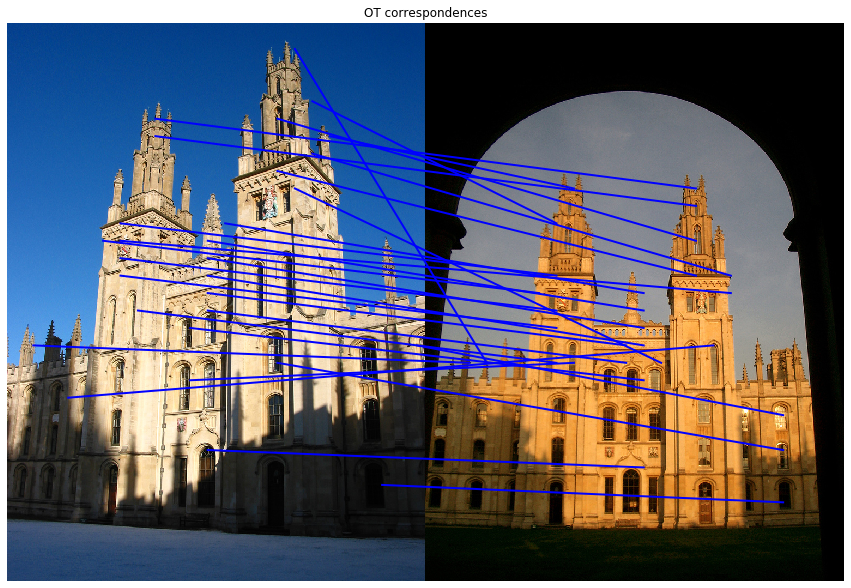

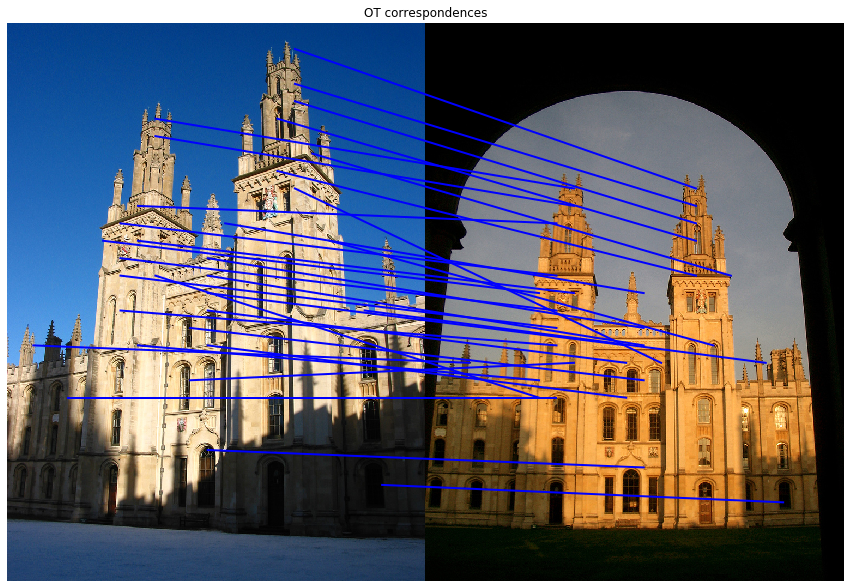

In [93]:
from cirtorch.datasets.genericdataset import ImagesFromList
for loc_scale in [0, 0.0015] :
    '''
    loader = torch.utils.data.DataLoader(
        ImagesFromList(root='', images=[qimage[0], qgnd_images[p_idx]], imsize=image_size, bbxs=None, transform=transform),
        batch_size=2, shuffle=False, num_workers=1, pin_memory=True
    ).__iter__()
    
    desc_1 = net.features(loader.get_item())
    desc_2 = net.features(loader.get_item())
    
    N, C, H, W = desc_1.shape
    
    desc_1 = desc_1.reshape(C, H*W).numpy()
    desc_2 = desc_2.reshape(C, H*W).numpy()
    
    grid = np.meshgrid(range(W), range(H))
    loc = np.concatenate((grid[1].flatten()[:, np.newaxis], grid[0].flatten()[:, np.newaxis]), axis=1)
    loc_1 = loc
    loc_2 = loc
    '''
    
    N_a = desc_1.shape[0]
    N_b = desc_2.shape[0]

    a = np.ones(N_a)
    a = scores_1
    a_sum = np.sum(a)

    b = np.ones(N_b)
    b = scores_2
    b_sum = np.sum(b)

    # a = np.concatenate((a, np.array([b_sum])))
    # b = np.concatenate((b, np.array([a_sum])))

    a = a / np.sum(a)
    b = b / np.sum(b)



    M_full = sklearn.metrics.pairwise_distances(
        np.concatenate((skprep.normalize(desc_1, axis=1), skprep.normalize(desc_2, axis=1)),
                                               axis=0), metric='euclidean')

    M_loc = sklearn.metrics.pairwise_distances(np.concatenate((loc_1, loc_2), axis=0), metric='euclidean')


    M = (1 - loc_scale) * M_full[:N_a, N_a:] + loc_scale * M_loc[:N_a, N_a:]

    P = ot.sinkhorn(a, b, M, 0.01, numItermax=2000)
    
    ind_0, ind_1, scores_0, _ = mutual_max(P, threshold=0.011 + loc_scale)
    
    mut_match = np.concatenate( (np.array(range(N_a))[:, np.newaxis], ind_0[:, np.newaxis]), axis=1 )
    mut_match = mut_match[ind_0 != -1, :]

    img_1 = mpimg.imread(qimage[0])
    img_2 = mpimg.imread(qgnd_images[0])

    img_1_name = qimage[0].split('/')[-1].split('.')[0]

    img_2_name = qgnd_images[0].split('/')[-1].split('.')[0]
    
    fig, ax = plt.subplots(figsize=(15,30))

    plot_matches(
        ax,
        img_1,
        img_2,
        loc_1,
        loc_2,
        mut_match,
        matches_color='b')
    ax.axis('off')
    ax.set_title('OT correspondences')
    # plt.savefig('ot_'  + '_' + img_1_name + '_' + img_2_name + '_' + args.output_image, dpi=300)
    plt.show()
    

In [94]:
select_1 = q_scores.flatten().argsort()[-20:][::-1] # q_scores[0] > 30 #top10??
loc_1 = q_locations[0, select_1, :]


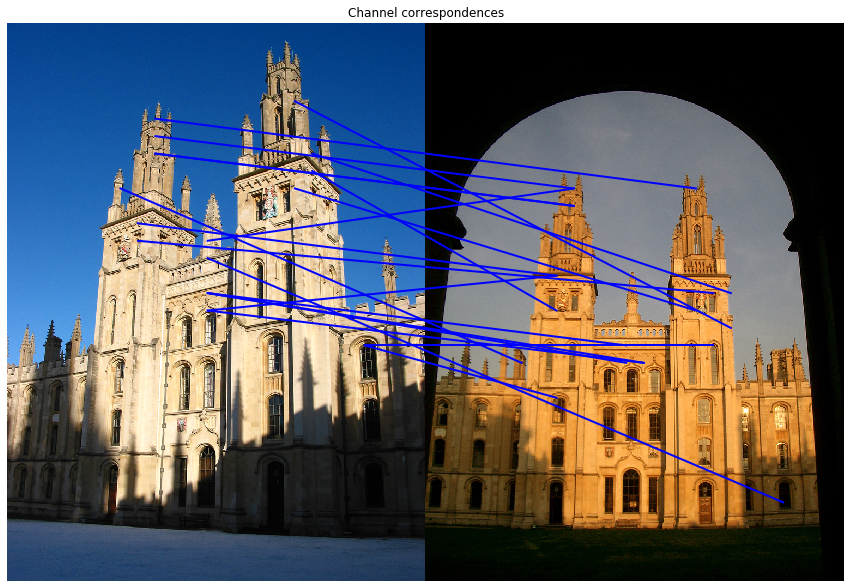

In [95]:
fig, ax = plt.subplots(figsize=(15,30))
plot_matches(
    ax,
    img_1,
    img_2,
    q_locations[0, :],
    qgnd_locations[0, :],
    np.repeat(select_1[:, np.newaxis], 2, axis=1),   #AAAAAAAAAAAAA
    matches_color='b')
ax.axis('off')
ax.set_title('Channel correspondences')
# plt.savefig('channel_' + img_2_name + '_' + args.output_image, dpi=300)
plt.show()